## Task 1 Part b)

In [2]:
import os
import re
import random
import time
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

In [1]:
categories_websites = {
    "Global Politics": [
    "https://www.bbc.com/news/world",  # BBC World News
    "https://www.economist.com/world/",  # The Economist's global coverage
    "https://foreignpolicy.com/"  # Foreign Policy magazine
    ],
    "Technology Startups": [
        "https://techcrunch.com/",  # Global tech news
        "https://www.theverge.com/",  # Major tech publication
        "https://www.wired.com/"  # Leading tech magazine
    ],
    "Classical Dance": [
        "https://www.narthaki.com/",
        "https://www.dancemagazine.com/",  # Global dance publication
        "https://worlddancefestival.net/"  # International dance festival site
    ],
    "World Cuisine": [
        "https://www.seriouseats.com/",  # Comprehensive food site
        "https://www.eater.com/",  # Global food culture
        "https://www.bonappetit.com/"  # International recipes
    ],
    "Environmental Conservation": [
        "https://www.nationalgeographic.com/environment/",  # Global leader
        "https://www.worldwildlife.org/",  # Global conservation
        "https://www.iucn.org/"  # International Union for Conservation of Nature
    ],
    "Education Policy": [
        "https://www.unesco.org/en/education",  # Global education authority
        "https://www.oecd.org/education/",  # International education research
        "https://www.timeshighereducation.com/"  # Global higher education news
    ],
    "Space Research": [
        "https://www.nasa.gov/",  # NASA
        "https://www.esa.int/",  # European Space Agency
        "https://global.jaxa.jp/"  # Japan Aerospace Exploration Agency
    ],
    "Film Industry": [
        "https://variety.com/",  # Global entertainment news
        "https://www.hollywoodreporter.com/",  # Entertainment industry news
        "https://www.imdb.com/"  # International movie database
    ],
    "Healthcare Innovation": [
        "https://www.who.int/",  # World Health Organization
        "https://www.nature.com/subjects/health-care",  # Research publication
        "https://www.thelancet.com/"  # Premier medical journal
    ],
    "Artificial Intelligence": [
        "https://www.deeplearning.ai/",  # AI education
        "https://openai.com/blog/",  # Leading AI research organization
        "https://www.technologyreview.com/topic/artificial-intelligence/"  # MIT tech publication
    ],
    "Traditional Crafts": [
        "https://www.etsy.com/",  # Global marketplace for crafts
        "https://craftcouncil.org/",  # American Craft Council
        "https://www.craftscouncil.org.uk/"  # UK craft organization
    ],
    "Agricultural Practices": [
        "https://www.fao.org/",  # UN Food and Agriculture Organization
        "https://modernfarmer.com/",  # Modern global agriculture
        "https://www.agriculture.com/"  # International farming information
    ],
    "Tourism": [
        "https://www.lonelyplanet.com/",  # Global travel guide
        "https://www.nationalgeographic.com/travel/",  # National Geographic travel
        "https://www.tripadvisor.com/"  # Global travel reviews
    ],
    "Renewable Energy": [
        "https://www.irena.org/",  # International Renewable Energy Agency
        "https://www.iea.org/",  # International Energy Agency
        "https://www.renewableenergyworld.com/"  # Global renewable energy news
    ],
    "Literature": [
        "https://www.newyorker.com/books",  # Influential literary reviews
        "https://lithub.com/",  # Global literary hub
        "https://www.theparisreview.org/"  # Prestigious literary magazine
    ],
    "Women Empowerment": [
        "https://www.unwomen.org/",  # UN Women
        "https://www.globalfundforwomen.org/",  # Global Fund for Women
        "https://womendeliver.org/"  # Global advocacy organization
    ],
    "Sports": [
        "https://www.espn.com/",  # Global sports network
        "https://www.sportingnews.com/",  # International sports coverage
        "https://www.olympic.org/"  # International Olympic Committee
    ],
    "Economic Policy": [
        "https://www.economist.com/",  # Global economic perspective
        "https://www.worldbank.org/",  # World Bank
        "https://www.imf.org/"  # International Monetary Fund
    ],
    "Classical Music": [
        "https://www.gramophone.co.uk/",  # Classical music magazine
        "https://www.classicfm.com/",  # Global classical music broadcaster
        "https://www.deutschegrammophon.com/"  # Historic classical music label
    ],
    "Historical Research": [
        "https://www.historytoday.com/",  # International history magazine
        "https://www.smithsonianmag.com/history/",  # Smithsonian history content
        "https://www.bl.uk/"  # British Library
    ]
}

In [3]:
# Download required NLTK resources if not already present
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
except:
    print("NLTK download failed, but continuing anyway")

In [4]:
def clean_text(text):
    """Clean and normalize text while maintaining readability."""
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove excessive whitespace while preserving paragraph breaks
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\n\s*\n', '\n\n', text)
    
    # Remove special characters but preserve sentence structure
    text = re.sub(r'[^\w\s.,!?;:\(\)\[\]\"\'-]', '', text)      
    # Trim leading/trailing whitespace
    text = text.strip()
    
    return text

def extract_useful_content(html_content):
    """Extract relevant content from HTML using BeautifulSoup."""
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Remove script, style, and navigation elements
    for element in soup(['script', 'style', 'nav', 'footer', 'header']):
        element.decompose()
    
    # Extract article titles with hierarchy
    titles = {
        'h1': [h.text.strip() for h in soup.find_all('h1') if h.text.strip()],
        'h2': [h.text.strip() for h in soup.find_all('h2') if h.text.strip()],
        'h3': [h.text.strip() for h in soup.find_all('h3') if h.text.strip()]
    }
    
    # Extract main content
    # Look for article or main content areas first
    content_areas = soup.select('article, .article, .content, .post, main, #main, #content, .entry')
    
    if content_areas:
        paragraphs = []
        for area in content_areas:
            paragraphs.extend([p.text.strip() for p in area.find_all('p') if p.text.strip()])
    else:
        # Fallback to all paragraphs
        paragraphs = [p.text.strip() for p in soup.find_all('p') if p.text.strip()]
    
    # Extract lists if available
    list_items = [li.text.strip() for li in soup.find_all('li') if li.text.strip()]
    
    # Combine all extracted content with proper formatting
    formatted_content = ""
    
    # Add title section with proper hierarchy
    if titles['h1']:
        formatted_content += "# " + "\n# ".join(titles['h1']) + "\n\n"
    if titles['h2']:
        formatted_content += "## " + "\n## ".join(titles['h2']) + "\n\n"
    if titles['h3']:
        formatted_content += "### " + "\n### ".join(titles['h3']) + "\n\n"
    
    # Add paragraph content with proper spacing
    if paragraphs:
        formatted_content += "\n\n".join(paragraphs) + "\n\n"
    
    # Add list items if available
    if list_items:
        formatted_content += "List items:\n" + "\n".join([f"• {item}" for item in list_items]) + "\n\n"
    
    return formatted_content

In [5]:

def crawl_website(url, headers, max_pages=3):
    """Crawl website with more in-depth content extraction."""
    print(f"  Crawling: {url}")
    all_text = []
    visited_urls = set()
    urls_to_visit = [url]
    
    try:
        for _ in range(max_pages):
            if not urls_to_visit:
                break
                
            current_url = urls_to_visit.pop(0)
            if current_url in visited_urls:
                continue
                
            visited_urls.add(current_url)
            print(f"    Visiting: {current_url}")
            
            try:
                response = requests.get(current_url, headers=headers, timeout=15)
                if response.status_code != 200:
                    print(f"    Failed: Status code {response.status_code}")
                    continue
                
                # Extract content
                content = extract_useful_content(response.text)
                cleaned_content = clean_text(content)
                if cleaned_content:
                    all_text.append(cleaned_content)
                
                # Find more links within the same domain
                if len(urls_to_visit) < max_pages:
                    soup = BeautifulSoup(response.text, 'html.parser')
                    try:
                        base_domain = re.search(r'https?://[^/]+', url).group(0)
                        
                        for link in soup.find_all('a', href=True):
                            href = link['href']
                            # Process relative URLs
                            if href.startswith('/'):
                                href = base_domain + href
                            # Only follow links from the same domain
                            if href.startswith(base_domain) and href not in visited_urls and href not in urls_to_visit:
                                urls_to_visit.append(href)
                    except:
                        print(f"    Error extracting links from {current_url}")
                
            except Exception as e:
                print(f"    Error processing {current_url}: {str(e)}")
            
            # Respect the website by waiting between requests
            time.sleep(random.uniform(3, 7))
    
    except Exception as e:
        print(f"  Error crawling {url}: {str(e)}")
    
    return "\n\n---\n\n".join(all_text)

In [6]:

def save_formatted_text(text, file_path):
    """Save text with proper formatting for readability."""
    try:
        # Split text into sentences
        sentences = sent_tokenize(text)
        
        # Organize into paragraphs (roughly 5-7 sentences per paragraph)
        paragraphs = []
        current_paragraph = []
        
        for sentence in sentences:
            current_paragraph.append(sentence)
            if len(current_paragraph) >= random.randint(3, 5):
                paragraphs.append(" ".join(current_paragraph))
                current_paragraph = []
        
        # Add any remaining sentences
        if current_paragraph:
            paragraphs.append(" ".join(current_paragraph))
        
        # Format with proper paragraph spacing
        formatted_text = "\n\n".join(paragraphs)
        
        # Save to file
        with open(file_path, 'w', encoding='utf-8') as f:
            f.write(formatted_text)
        
        return len(formatted_text)
    except Exception as e:
        print(f"  Error saving to {file_path}: {str(e)}")
        return 0

def create_category_summary(category_text, num_words=100):
    """Create a summary of the category content."""
    try:
        # Remove stopwords for term frequency analysis
        stop_words = set(stopwords.words('english'))
        words = []
        for text in category_text:
            try:
                words.extend([word.lower() for word in word_tokenize(text) 
                             if word.isalpha() and word.lower() not in stop_words])
            except:
                pass
        
        # Get word frequency
        from collections import Counter
        word_freq = Counter(words)
        
        # Get most common words
        most_common = word_freq.most_common(20)
        
        summary = f"Top terms: {', '.join([word for word, count in most_common])}\n\n"
        summary += f"Total content: {sum(len(text) for text in category_text)} characters\n"
        summary += f"Approximate word count: {sum(len(text.split()) for text in category_text)} words\n"
        
        return summary
    except Exception as e:
        print(f"  Error creating summary: {str(e)}")
        return "Error creating summary"


In [ ]:
# Main execution
base_folder = "GlobalContextualTextCorpus"
os.makedirs(base_folder, exist_ok=True)

# User agents list for rotation
user_agents = [
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:90.0) Gecko/20100101 Firefox/90.0',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.1.2 Safari/605.1.15'
]

for category, websites in categories_websites.items():
    print(f"Processing category: {category}")
    category_folder = os.path.join(base_folder, category.replace(' ', '_'))
    os.makedirs(category_folder, exist_ok=True)
    
    category_text = []
    
    for i, website in enumerate(websites):
        # Rotate user agents
        headers = {
            'User-Agent': random.choice(user_agents),
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5',
            'Referer': 'https://www.google.com/'
        }
        
        # Crawl website (with deeper crawling - visit up to 3 pages per website)
        text = crawl_website(website, headers, max_pages=3)
        
        if text:
            # Save individual website content
            site_name = re.sub(r'https?://(www\.)?([^/]+).*', r'\2', website)
            file_path = os.path.join(category_folder, f"{site_name}.txt")
            char_count = save_formatted_text(text, file_path)
            print(f"    Saved {char_count} characters from {site_name}")
            
            category_text.append(text)
    
    # Create category summary
    if category_text:
        # Combine all text from websites in this category for master file
        combined_text = "\n\n====================\n\n".join(category_text)
        
        # Create and save summary
        summary = create_category_summary(category_text)
        summary_path = os.path.join(category_folder, "_summary.txt")
        with open(summary_path, 'w', encoding='utf-8') as f:
            f.write(summary)
        
        # Save combined category file
        master_path = os.path.join(category_folder, "_all_content.txt")
        char_count = save_formatted_text(combined_text, master_path)
        print(f"  Saved {char_count} characters combined for {category}")
    else:
        print(f"  No content gathered for {category}")

print("Text dataset collection complete.")

## Data analysis

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from wordcloud import WordCloud
import matplotlib.cm as cm
import warnings
import json
from collections import Counter
from tqdm import tqdm

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Download NLTK resources if not already present
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
except:
    print("NLTK download failed, but continuing anyway")
    
# Load spaCy model if available
try:
    nlp = spacy.load("en_core_web_sm")
except:
    print("spaCy model not available. Install with 'python -m spacy download en_core_web_sm'")
    nlp = None

class CrossDomainKnowledgeGraph:
    """
    A system for creating and analyzing cross-domain knowledge graphs
    from text corpora across different subject areas.
    """
    
    def __init__(self, base_folder="GlobalContextualTextCorpus"):
        """Initialize the knowledge graph generator."""
        self.base_folder = base_folder
        self.categories = []
        self.texts = {}
        self.category_keywords = {}
        self.key_concepts = {}
        self.cross_references = {}
        self.vectorizer = None
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.category_embeddings = {}
        self.entity_categories = {}
        self.graph = nx.Graph()
        self.doc2vec_model = None
        self.output_folder = "CrossDomainAnalysis"
        
        # Custom subject-specific stopwords
        self.custom_stopwords = {
            "general": ["also", "one", "two", "three", "may", "many", "using", "can", "use", 
                       "used", "like", "even", "well", "first", "often", "however", "though",
                       "without", "within", "although", "among", "around", "because", "become",
                       "comes", "either", "else", "etc", "ever", "every", "example"],
            "article_words": ["article", "author", "published", "journal", "research", "study", 
                             "paper", "chapter", "section", "page", "figure", "table", "et", "al"]
        }
        
        # Ensure output folder exists
        os.makedirs(self.output_folder, exist_ok=True)
        
    def load_corpus(self, file_pattern="_all_content.txt"):
        """
        Load text data from category folders, looking for the specified file pattern.
        
        Args:
            file_pattern: Pattern to match content files (default: "_all_content.txt")
            
        Returns:
            Number of categories loaded
        """
        try:
            print(f"Loading corpus from {self.base_folder}...")
            
            # Check if base folder exists
            if not os.path.isdir(self.base_folder):
                print(f"Error: Base folder '{self.base_folder}' not found.")
                return 0
                
            # Scan for category folders
            category_dirs = []
            for item in os.listdir(self.base_folder):
                full_path = os.path.join(self.base_folder, item)
                if os.path.isdir(full_path):
                    category_dirs.append(item)
            
            if not category_dirs:
                print(f"No category folders found in {self.base_folder}")
                return 0
                
            print(f"Found {len(category_dirs)} potential category folders")
            
            # Process each category
            for category_dir in category_dirs:
                category_path = os.path.join(self.base_folder, category_dir)
                content_file = os.path.join(category_path, file_pattern)
                
                # Check if the content file exists
                if os.path.isfile(content_file):
                    # Read content file
                    try:
                        with open(content_file, 'r', encoding='utf-8') as f:
                            content = f.read()
                            
                        # Clean category name
                        category_name = category_dir.replace('_', ' ')
                        
                        # Store category and content
                        self.categories.append(category_name)
                        self.texts[category_name] = content
                        
                        print(f"  ✓ Loaded '{category_name}' ({len(content)} characters)")
                    except Exception as e:
                        print(f"  ✗ Error reading {content_file}: {str(e)}")
                else:
                    print(f"  ✗ No {file_pattern} found in {category_path}")
            
            print(f"Successfully loaded {len(self.categories)} categories")
            return len(self.categories)
            
        except Exception as e:
            print(f"Error loading corpus: {str(e)}")
            return 0
    
    def preprocess_text(self, text, remove_custom_stopwords=True):
        """Preprocess text for analysis."""
        if not text:
            return ""
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        
        # Remove special characters but keep sentence structure
        text = re.sub(r'[^\w\s.,!?;:\-]', ' ', text)
        
        # Replace numbers with space
        text = re.sub(r'\d+', ' ', text)
        
        # Tokenize
        words = word_tokenize(text)
        
        # Remove stopwords and lemmatize
        filtered_words = []
        for word in words:
            # Skip short words and stopwords
            if len(word) <= 2 or word in self.stop_words:
                continue
                
            # Skip custom stopwords if enabled
            if remove_custom_stopwords:
                if word in self.custom_stopwords["general"] or word in self.custom_stopwords["article_words"]:
                    continue
            
            # Lemmatize and add to filtered words
            filtered_words.append(self.lemmatizer.lemmatize(word))
        
        return ' '.join(filtered_words)
    
    def extract_key_concepts(self, top_n=25, min_df=2):
        """
        Extract key concepts from each category using TF-IDF.
        
        Args:
            top_n: Number of top concepts to extract per category
            min_df: Minimum document frequency for TF-IDF
        """
        if not self.categories:
            print("No categories loaded. Please load corpus first.")
            return
        
        print(f"Extracting key concepts from {len(self.categories)} categories...")
        
        # Preprocess texts
        preprocessed_texts = {category: self.preprocess_text(text) 
                             for category, text in self.texts.items()}
        
        # Create corpus and category list for vectorization
        corpus = []
        corpus_categories = []
        for category, text in preprocessed_texts.items():
            corpus.append(text)
            corpus_categories.append(category)
        
        # Vectorize the corpus
        self.vectorizer = TfidfVectorizer(max_features=10000, min_df=min_df, max_df=0.8)
        tfidf_matrix = self.vectorizer.fit_transform(corpus)
        
        # Get feature names
        feature_names = self.vectorizer.get_feature_names_out()
        
        # Extract top concepts for each category
        for i, category in enumerate(corpus_categories):
            # Get feature indices sorted by importance
            feature_indices = tfidf_matrix[i].nonzero()[1]
            tfidf_scores = [(feature_names[index], tfidf_matrix[i, index]) 
                           for index in feature_indices]
            
            # Sort by score
            tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
            
            # Store top concepts
            self.category_keywords[category] = tfidf_scores[:top_n]
            
            # Print sample of top concepts
            concept_sample = ', '.join([concept for concept, _ in tfidf_scores[:5]])
            print(f"  ✓ {category}: {concept_sample}...")
        
        return self.category_keywords
    
    def find_cross_domain_connections(self, threshold=0.2):
        """
        Find connections between concepts across different domains.
        
        Args:
            threshold: Similarity threshold for considering concepts related
        """
        if not self.category_keywords:
            print("No key concepts extracted. Please run extract_key_concepts first.")
            return
        
        print("Analyzing cross-domain connections...")
        
        # Prepare list of all key concepts
        all_concepts = {}
        for category, concepts in self.category_keywords.items():
            for concept, score in concepts:
                if concept not in all_concepts:
                    all_concepts[concept] = {'score': score, 'categories': [category]}
                else:
                    all_concepts[concept]['categories'].append(category)
                    all_concepts[concept]['score'] = max(all_concepts[concept]['score'], score)
        
        # Find connections between concepts from different domains
        self.cross_references = {}
        
        # Process each category
        for category in self.categories:
            # Extract concepts for this category
            category_concepts = [concept for concept, _ in self.category_keywords[category]]
            
            # Find related concepts from other categories
            related_concepts = {}
            
            for concept in category_concepts:
                # Skip concepts with underscores or less than 3 chars
                if '_' in concept or len(concept) < 3:
                    continue
                    
                # Search for this concept in other categories' texts
                for other_category in self.categories:
                    if other_category == category:
                        continue
                        
                    # Check for direct matches or similar terms
                    other_text = self.texts[other_category].lower()
                    
                    # Direct match (frequency of concept in other category)
                    match_pattern = r'\b' + re.escape(concept) + r'\b'
                    matches = re.findall(match_pattern, other_text)
                    match_count = len(matches)
                    
                    if match_count >= 3:  # At least 3 occurrences
                        if concept not in related_concepts:
                            related_concepts[concept] = []
                        
                        related_concepts[concept].append({
                            'category': other_category,
                            'frequency': match_count,
                            'score': match_count / len(other_text.split()) * 1000  # Normalized score
                        })
            
            # Store related concepts for this category
            self.cross_references[category] = related_concepts
            
            # Show sample of cross-references
            concept_count = sum(len(refs) for refs in related_concepts.values())
            print(f"  ✓ {category}: Found {concept_count} cross-domain references")
        
        return self.cross_references
    
    def build_knowledge_graph(self, max_nodes=200, min_edge_weight=3):
        """
        Build a knowledge graph connecting concepts across domains.
        
        Args:
            max_nodes: Maximum number of nodes to include
            min_edge_weight: Minimum edge weight to include
        """
        if not self.cross_references:
            print("No cross-references found. Please run find_cross_domain_connections first.")
            return
        
        print("Building knowledge graph...")
        
        # Create a new graph
        self.graph = nx.Graph()
        
        # Add category nodes
        for category in self.categories:
            self.graph.add_node(category, type='category', size=30)
        
        # Track all concept nodes and their connections
        concept_connections = {}
        
        # Process cross-references to build edges
        for category, concepts in self.cross_references.items():
            for concept, references in concepts.items():
                # Add concept node if it appears in multiple categories
                if len(references) > 0:
                    if concept not in concept_connections:
                        concept_connections[concept] = {
                            'categories': [category],
                            'total_weight': 0
                        }
                    else:
                        concept_connections[concept]['categories'].append(category)
                    
                    # Add connections to other categories
                    for ref in references:
                        other_category = ref['category']
                        weight = ref['frequency']
                        
                        if weight >= min_edge_weight:
                            concept_connections[concept]['total_weight'] += weight
        
        # Sort concepts by total weight
        sorted_concepts = sorted(concept_connections.items(), 
                               key=lambda x: x[1]['total_weight'], 
                               reverse=True)
        
        # Add top concept nodes and their edges (limited by max_nodes)
        nodes_added = len(self.categories)  # Start with category nodes
        
        for concept, data in sorted_concepts:
            if nodes_added >= max_nodes:
                break
                
            # Add concept node
            self.graph.add_node(concept, type='concept', 
                               size=10 + min(data['total_weight'], 20),
                               weight=data['total_weight'])
            nodes_added += 1
            
            # Add edges to categories
            for category in data['categories']:
                self.graph.add_edge(category, concept, weight=5)
                
            # Track which categories this entity belongs to
            self.entity_categories[concept] = data['categories']
        
        print(f"Knowledge graph built with {len(self.graph.nodes)} nodes and {len(self.graph.edges)} edges")
        return self.graph
    
    def visualize_graph(self, layout='spring', figsize=(14, 12)):
        """
        Visualize the knowledge graph.
        
        Args:
            layout: Graph layout algorithm ('spring', 'kamada_kawai', or 'circular')
            figsize: Figure size tuple
        """
        if not self.graph or len(self.graph.nodes) == 0:
            print("No graph to visualize. Please build the knowledge graph first.")
            return
        
        print("Visualizing knowledge graph...")
        
        # Create figure
        plt.figure(figsize=figsize)
        
        # Determine layout
        if layout == 'spring':
            pos = nx.spring_layout(self.graph, k=0.15, iterations=50)
        elif layout == 'kamada_kawai':
            pos = nx.kamada_kawai_layout(self.graph)
        elif layout == 'circular':
            pos = nx.circular_layout(self.graph)
        else:
            print(f"Unknown layout '{layout}'. Using spring layout.")
            pos = nx.spring_layout(self.graph, k=0.15, iterations=50)
        
        # Get node attributes
        node_types = nx.get_node_attributes(self.graph, 'type')
        node_sizes = nx.get_node_attributes(self.graph, 'size')
        
        # Default values for missing attributes
        default_size = 10
        
        # Prepare node lists by type
        category_nodes = [node for node, type in node_types.items() if type == 'category']
        concept_nodes = [node for node, type in node_types.items() if type == 'concept']
        
        # Prepare node sizes
        category_sizes = [node_sizes.get(node, default_size*3) for node in category_nodes]
        concept_sizes = [node_sizes.get(node, default_size) for node in concept_nodes]
        
        # Draw edges
        nx.draw_networkx_edges(self.graph, pos, alpha=0.3, width=0.5)
        
        # Draw nodes by type
        nx.draw_networkx_nodes(self.graph, pos, nodelist=category_nodes, 
                              node_size=category_sizes, node_color='blue', 
                              alpha=0.7, label='Categories')
        
        nx.draw_networkx_nodes(self.graph, pos, nodelist=concept_nodes, 
                              node_size=concept_sizes, node_color='red', 
                              alpha=0.5, label='Concepts')
        
        # Draw labels only for category nodes and important concept nodes
        important_concept_nodes = [node for node in concept_nodes 
                                 if node_sizes.get(node, 0) > default_size*2]
        
        label_nodes = category_nodes + important_concept_nodes
        labels = {node: node for node in label_nodes}
        
        nx.draw_networkx_labels(self.graph, pos, labels=labels, font_size=8)
        
        # Add legend and title
        plt.legend()
        plt.title('Cross-Domain Knowledge Graph')
        plt.axis('off')
        
        # Save the visualization
        graph_path = os.path.join(self.output_folder, "knowledge_graph.png")
        plt.savefig(graph_path, dpi=300, bbox_inches='tight')
        print(f"Graph visualization saved to {graph_path}")
        plt.close()
    
    def analyze_category_relationships(self):
        """Analyze relationships between categories based on shared concepts."""
        if not self.cross_references:
            print("No cross-references found. Please run find_cross_domain_connections first.")
            return
            
        print("Analyzing category relationships...")
        
        # Create a matrix of relationships between categories
        n_categories = len(self.categories)
        relationship_matrix = np.zeros((n_categories, n_categories))
        
        for i, category1 in enumerate(self.categories):
            for j, category2 in enumerate(self.categories):
                if i == j:
                    continue
                
                # Count shared concepts
                shared_concept_count = 0
                
                # Check concepts from category1 that appear in category2
                if category1 in self.cross_references:
                    for concept, references in self.cross_references[category1].items():
                        for ref in references:
                            if ref['category'] == category2:
                                shared_concept_count += 1
                
                # Check concepts from category2 that appear in category1
                if category2 in self.cross_references:
                    for concept, references in self.cross_references[category2].items():
                        for ref in references:
                            if ref['category'] == category1:
                                shared_concept_count += 1
                
                relationship_matrix[i, j] = shared_concept_count
        
        # Convert to pandas DataFrame
        relationship_df = pd.DataFrame(relationship_matrix, 
                                     index=self.categories, 
                                     columns=self.categories)
        
        # Visualize the relationship matrix as a heatmap
        plt.figure(figsize=(14, 12))
        sns.heatmap(relationship_df, annot=True, cmap='Blues', fmt='g')
        plt.title('Relationships Between Categories (Shared Concepts)')
        plt.tight_layout()
        
        # Save the visualization
        heatmap_path = os.path.join(self.output_folder, "category_relationships.png")
        plt.savefig(heatmap_path, dpi=300, bbox_inches='tight')
        print(f"Category relationship heatmap saved to {heatmap_path}")
        plt.close()
        
        return relationship_df
    
    def generate_wordclouds(self):
        """Generate word clouds for each category."""
        if not self.categories:
            print("No categories loaded. Please load corpus first.")
            return
            
        print("Generating word clouds for each category...")
        
        # Process each category
        for category in self.categories:
            # Preprocess text
            preprocessed_text = self.preprocess_text(self.texts[category])
            
            if not preprocessed_text:
                print(f"  ✗ {category}: No content after preprocessing")
                continue
            
            # Generate word cloud
            wordcloud = WordCloud(
                width=800, height=400,
                background_color='white',
                max_words=150,
                colormap='viridis',
                contour_width=1, 
                contour_color='steelblue'
            ).generate(preprocessed_text)
            
            # Plot
            plt.figure(figsize=(12, 6))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            plt.title(f"{category} - Key Concepts")
            
            # Save the word cloud
            filename = f"wordcloud_{category.replace(' ', '_')}.png"
            plt.savefig(os.path.join(self.output_folder, filename))
            print(f"  ✓ {category} word cloud saved")
            plt.close()
    
    def train_doc2vec_model(self, vector_size=100, min_count=5, epochs=40):
        """
        Train a Doc2Vec model on all category documents.
        
        Args:
            vector_size: Dimensionality of the feature vectors
            min_count: Minimum frequency of words to consider
            epochs: Number of training epochs
        """
        if not self.categories:
            print("No categories loaded. Please load corpus first.")
            return
            
        print("Training Doc2Vec model on corpus...")
        
        # Prepare documents for training
        tagged_docs = []
        for i, category in enumerate(self.categories):
            # Preprocess and tokenize
            preprocessed = self.preprocess_text(self.texts[category], remove_custom_stopwords=False)
            tokens = preprocessed.split()
            
            # Add as tagged document
            tagged_docs.append(TaggedDocument(tokens, [category]))
        
        # Train model
        self.doc2vec_model = Doc2Vec(
            vector_size=vector_size,
            min_count=min_count,
            epochs=epochs,
            dm=1,  # Using distributed memory (PV-DM)
            workers=4
        )
        
        # Build vocabulary
        self.doc2vec_model.build_vocab(tagged_docs)
        
        # Train model
        self.doc2vec_model.train(tagged_docs, total_examples=self.doc2vec_model.corpus_count, epochs=self.doc2vec_model.epochs)
        
        # Get embeddings for each category
        for category in self.categories:
            self.category_embeddings[category] = self.doc2vec_model.infer_vector(
                self.preprocess_text(self.texts[category]).split()
            )
            
        print(f"Doc2Vec model trained with {vector_size} dimensions")
        
        # Save model
        model_path = os.path.join(self.output_folder, "doc2vec_model")
        self.doc2vec_model.save(model_path)
        print(f"Model saved to {model_path}")
        
        return self.doc2vec_model
    
    def visualize_category_embeddings(self):
        """Visualize category embeddings in a 2D space using dimensionality reduction."""
        if not self.category_embeddings:
            print("No category embeddings available. Please train the Doc2Vec model first.")
            return
            
        print("Visualizing category embeddings...")
        
        # Extract embeddings matrix
        embeddings = np.array([self.category_embeddings[cat] for cat in self.categories])
        
        # Reduce dimensions using PCA for visualization
        pca = TruncatedSVD(n_components=2)
        embeddings_2d = pca.fit_transform(embeddings)
        
        # Plot
        plt.figure(figsize=(12, 10))
        
        # Plot points
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue', alpha=0.6, s=100)
        
        # Add labels
        for i, category in enumerate(self.categories):
            plt.annotate(category, (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                        fontsize=12, ha='center', va='center',
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        
        plt.title("Semantic Relationships Between Categories")
        plt.xlabel(f"Dimension 1 (Explains {pca.explained_variance_ratio_[0]:.2%} variance)")
        plt.ylabel(f"Dimension 2 (Explains {pca.explained_variance_ratio_[1]:.2%} variance)")
        plt.grid(alpha=0.3)
        
        # Save the visualization
        embedding_path = os.path.join(self.output_folder, "category_embeddings.png")
        plt.savefig(embedding_path, dpi=300, bbox_inches='tight')
        print(f"Category embeddings visualization saved to {embedding_path}")
        plt.close()
    
    def find_similar_categories(self, query_category, top_n=3):
        """
        Find categories most similar to the specified category.
        
        Args:
            query_category: The category to compare others against
            top_n: Number of similar categories to return
        """
        if not self.category_embeddings:
            print("No category embeddings available. Please train the Doc2Vec model first.")
            return []
            
        if query_category not in self.categories:
            print(f"Category '{query_category}' not found.")
            return []
            
        # Get query embedding
        query_embedding = self.category_embeddings[query_category]
        
        # Calculate similarity with all other categories
        similarities = {}
        for category, embedding in self.category_embeddings.items():
            if category != query_category:
                # Compute cosine similarity
                similarity = cosine_similarity(
                    [query_embedding],
                    [embedding]
                )[0][0]
                
                similarities[category] = similarity
        
        # Sort by similarity
        similar_categories = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
        
        # Return top N
        return similar_categories[:top_n]
    
    def extract_common_entities(self, min_count=3):
        """
        Extract named entities that appear across multiple categories.
        
        Args:
            min_count: Minimum number of categories an entity must appear in
        """
        if not nlp:
            print("spaCy model not available. Skipping entity extraction.")
            return {}
            
        if not self.categories:
            print("No categories loaded. Please load corpus first.")
            return {}
            
        print("Extracting named entities across categories...")
        
        # Track entities and their category occurrences
        entity_categories = {}
        
        # Process each category
        for category in self.categories:
            print(f"  Processing '{category}'...")
            text = self.texts[category]
            
            # Split text into manageable chunks (spaCy has a text length limit)
            max_chunk_size = 100000  # 100K characters per chunk
            text_chunks = [text[i:i+max_chunk_size] for i in range(0, len(text), max_chunk_size)]
            
            # Track entities found in this category
            category_entities = {}
            
            # Process each chunk
            for chunk in text_chunks:
                try:
                    # Process with spaCy
                    doc = nlp(chunk)
                    
                    # Extract entities
                    for ent in doc.ents:
                        if ent.label_ in ['ORG', 'PERSON', 'GPE', 'LOC', 'WORK_OF_ART', 'EVENT', 'FAC', 'PRODUCT']:
                            entity_text = ent.text.strip()
                            
                            # Skip very short entities or those with unwanted characters
                            if len(entity_text) < 3 or re.search(r'[\d_]', entity_text):
                                continue
                                
                            # Count in this category
                            if entity_text not in category_entities:
                                category_entities[entity_text] = {'type': ent.label_, 'count': 1}
                            else:
                                category_entities[entity_text]['count'] += 1
                except Exception as e:
                    print(f"  Error processing text chunk: {str(e)}")
            
            # Add entities with sufficient counts to the global tracking
            for entity, data in category_entities.items():
                if data['count'] >= min_count:
                    if entity not in entity_categories:
                        entity_categories[entity] = {
                            'type': data['type'],
                            'categories': [category],
                            'total_count': data['count']
                        }
                    else:
                        entity_categories[entity]['categories'].append(category)
                        entity_categories[entity]['total_count'] += data['count']
        
        # Filter for entities that appear in multiple categories
        cross_domain_entities = {entity: data for entity, data in entity_categories.items()
                               if len(data['categories']) >= min_count}
        
        print(f"Found {len(cross_domain_entities)} entities that appear in {min_count}+ categories")
        
        # Save to file
        entities_path = os.path.join(self.output_folder, "cross_domain_entities.json")
        with open(entities_path, 'w', encoding='utf-8') as f:
            json.dump(cross_domain_entities, f, indent=2, ensure_ascii=False)
        
        return cross_domain_entities
    
    def create_cross_domain_report(self):
        """Create a comprehensive report of cross-domain connections."""
        if not self.categories or not self.cross_references:
            print("Missing data. Please run analysis steps first.")
            return
            
        print("Generating cross-domain analysis report...")
        
        # Create report
        report = ["# Cross-Domain Knowledge Analysis Report\n\n"]
        
        # Add summary information
        report.append(f"## Summary\n\n")
        report.append(f"- **Total Categories Analyzed:** {len(self.categories)}\n")
        report.append(f"- **Total Concepts Extracted:** {sum(len(kws) for kws in self.category_keywords.values())}\n")
        
        if self.graph:
            report.append(f"- **Knowledge Graph Size:** {len(self.graph.nodes)} nodes, {len(self.graph.edges)} connections\n")
        
        report.append("\n## Categories Analyzed\n\n")
        for category in sorted(self.categories):
            report.append(f"- {category}\n")
        
        # Add section for each category
        report.append("\n## Category Analysis\n")
        
        for category in sorted(self.categories):
            report.append(f"\n### {category}\n\n")
            
            # Add key concepts
            if category in self.category_keywords:
                report.append("#### Key Concepts\n\n")
                for concept, score in self.category_keywords[category][:10]:
                    report.append(f"- {concept} *(score: {score:.4f})*\n")
            
            # Add cross-domain references
            if category in self.cross_references and self.cross_references[category]:
                report.append("\n#### Cross-Domain Connections\n\n")
                
                # Group by related category
                category_references = {}
                for concept, references in self.cross_references[category].items():
                    for ref in references:
                        related_category = ref['category']
                        if related_category not in category_references:
                            category_references[related_category] = []
                        
                        category_references[related_category].append({
                            'concept': concept,
                            'frequency': ref['frequency']
                        })
                
                # List connections by category
                for related_category, concepts in sorted(category_references.items()):
                    # Sort concepts by frequency
                    sorted_concepts = sorted(concepts, key=lambda x: x['frequency'], reverse=True)
                    concept_list = [f"{c['concept']} ({c['frequency']})" for c in sorted_concepts[:5]]
                    
                    report.append(f"- **{related_category}**: {', '.join(concept_list)}\n")
        
        # Add similar categories section if embeddings are available
        if self.category_embeddings:
            report.append("\n## Similar Categories\n\n")
            
            for category in sorted(self.categories):
                similar = self.find_similar_categories(category, top_n=3)
                if similar:
                    report.append(f"### {category} is most similar to:\n\n")
                    for similar_cat, score in similar:
                        report.append(f"- {similar_cat} *(similarity: {score:.4f})*\n")
                    report.append("\n")
        
        # Write report to file
        report_path = os.path.join(self.output_folder, "cross_domain_report.md")
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write("".join(report))
            
        print(f"Cross-domain report saved to {report_path}")
        return "".join(report)
    
    def analyze(self):
        """Run the complete analysis pipeline."""
        # Load corpus
        loaded_count = self.load_corpus()
        if loaded_count == 0:
            print("No data loaded. Cannot proceed with analysis.")
            return False
        
        # Extract key concepts
        self.extract_key_concepts()
        
        # Find cross-domain connections
        self.find_cross_domain_connections()
        
        # Build and visualize knowledge graph
        self.build_knowledge_graph()
        self.visualize_graph()
        
        # Analyze category relationships
        self.analyze_category_relationships()
        
        # Generate word clouds
        self.generate_wordclouds()
        
        # Train Doc2Vec model and visualize embeddings
        self.train_doc2vec_model()
        self.visualize_category_embeddings()
        
        # Extract common entities
        if nlp:
            self.extract_common_entities()
        
        # Create final report
        self.create_cross_domain_report()
        
        print("Analysis complete! Results saved to the output folder.")
        return True

# Example usage
if __name__ == "__main__":
    # Initialize the analyzer
    analyzer = CrossDomainKnowledgeGraph()
    
    # Run complete analysis
    analyzer.analyze()

## Visualizing 
1. WordClouds 
2. Knowledge Graph 
3. Embeddings
4. Cross domain Report

In [7]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display, Markdown, HTML
import pandas as pd
import re

In [8]:
class VisualizationLoader:
    """
    A class to load and display visualization files from the CrossDomainAnalysis folder
    in a Jupyter notebook.
    """
    
    def __init__(self, folder_path="CrossDomainAnalysis"):
        """Initialize with path to the analysis folder."""
        self.folder_path = folder_path
        
        # Check if the folder exists
        if not os.path.exists(folder_path):
            print(f"Error: Folder '{folder_path}' not found.")
            return
            
        # Locate visualization files
        self.wordcloud_files = sorted(glob.glob(os.path.join(folder_path, "wordcloud_*.png")))
        self.embedding_file = os.path.join(folder_path, "category_embeddings.png")
        self.relationship_file = os.path.join(folder_path, "category_relationships.png")
        self.knowledge_graph_file = os.path.join(folder_path, "knowledge_graph.png")
        self.report_file = os.path.join(folder_path, "cross_domain_report.md")
        
        # List of all visualization files
        self.all_files = glob.glob(os.path.join(folder_path, "*.png")) + glob.glob(os.path.join(folder_path, "*.md"))
        
        # Print summary of found files
        print(f"Found {len(self.wordcloud_files)} wordcloud files")
        print(f"Found knowledge graph: {os.path.exists(self.knowledge_graph_file)}")
        print(f"Found category embeddings: {os.path.exists(self.embedding_file)}")
        print(f"Found cross-domain report: {os.path.exists(self.report_file)}")
        
    def display_wordclouds(self, n_cols=3, figsize=(15, 5*5)):
        """
        Display wordcloud visualizations in a grid.
        
        Args:
            n_cols: Number of columns in the grid
            figsize: Figure size as (width, height)
        """
        if not self.wordcloud_files:
            print("No wordcloud files found.")
            return
            
        # Calculate grid dimensions
        n_files = len(self.wordcloud_files)
        n_rows = (n_files + n_cols - 1) // n_cols
        
        # Create figure
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        
        # Flatten axes array for easier indexing
        if n_rows > 1 and n_cols > 1:
            axes = axes.flatten()
        elif n_rows == 1 and n_cols > 1:
            axes = axes  # Already a 1D array
        elif n_cols == 1 and n_rows > 1:
            axes = axes.flatten()
        else:
            axes = [axes]  # Make it a list for consistent indexing
        
        # Display each wordcloud
        for i, file_path in enumerate(self.wordcloud_files):
            if i < len(axes):
                # Extract category name from filename
                category = os.path.basename(file_path).replace("wordcloud_", "").replace(".png", "").replace("_", " ")
                
                # Display image
                img = mpimg.imread(file_path)
                axes[i].imshow(img)
                axes[i].set_title(category)
                axes[i].axis('off')
                
        # Hide unused subplots
        for i in range(n_files, len(axes)):
            fig.delaxes(axes[i])
            
        plt.tight_layout()
        plt.show()
        
    def display_knowledge_graph(self, figsize=(12, 10)):
        """Display the knowledge graph visualization."""
        if not os.path.exists(self.knowledge_graph_file):
            print(f"Knowledge graph file not found: {self.knowledge_graph_file}")
            return
            
        # Display image
        img = mpimg.imread(self.knowledge_graph_file)
        plt.figure(figsize=figsize)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Cross-Domain Knowledge Graph")
        plt.show()
        
    def display_category_embeddings(self, figsize=(12, 10)):
        """Display the category embeddings visualization."""
        if not os.path.exists(self.embedding_file):
            print(f"Category embeddings file not found: {self.embedding_file}")
            return
            
        # Display image
        img = mpimg.imread(self.embedding_file)
        plt.figure(figsize=figsize)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Category Embeddings")
        plt.show()
        
    def display_category_relationships(self, figsize=(12, 10)):
        """Display the category relationships visualization."""
        if not os.path.exists(self.relationship_file):
            print(f"Category relationships file not found: {self.relationship_file}")
            return
            
        # Display image
        img = mpimg.imread(self.relationship_file)
        plt.figure(figsize=figsize)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Category Relationships")
        plt.show()
        
    def display_report(self):
        """Display the cross-domain analysis report."""
        if not os.path.exists(self.report_file):
            print(f"Report file not found: {self.report_file}")
            return
            
        # Read report content
        with open(self.report_file, 'r', encoding='utf-8') as f:
            report_content = f.read()
            
        # Display as Markdown
        display(Markdown(report_content))
        
    def display_file_by_name(self, filename, figsize=(12, 10)):
        """
        Display a specific file by name.
        
        Args:
            filename: Name of the file (with or without extension)
            figsize: Figure size for image files
        """
        # Find matching files
        matches = [f for f in self.all_files if os.path.basename(f).startswith(filename)]
        
        if not matches:
            print(f"No files found matching '{filename}'")
            return
            
        file_path = matches[0]
        file_ext = os.path.splitext(file_path)[1].lower()
        
        if file_ext in ['.png', '.jpg', '.jpeg']:
            # Display image
            img = mpimg.imread(file_path)
            plt.figure(figsize=figsize)
            plt.imshow(img)
            plt.axis('off')
            plt.title(os.path.basename(file_path))
            plt.show()
        elif file_ext == '.md':
            # Display markdown
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
            display(Markdown(content))
        else:
            print(f"Cannot display file of type {file_ext}: {file_path}")
            
    def list_all_files(self):
        """List all files in the visualization folder."""
        print("Available visualization files:")
        for file in self.all_files:
            print(f"- {os.path.basename(file)}")

Found 20 wordcloud files
Found knowledge graph: True
Found category embeddings: True
Found cross-domain report: True
Available visualization files:
- category_embeddings.png
- category_relationships.png
- knowledge_graph.png
- wordcloud_Agricultural_Practices.png
- wordcloud_Artificial_Intelligence.png
- wordcloud_Classical_Dance.png
- wordcloud_Classical_Music.png
- wordcloud_Economic_Policy.png
- wordcloud_Education_Policy.png
- wordcloud_Environmental_Conservation.png
- wordcloud_Film_Industry.png
- wordcloud_Global_Politics.png
- wordcloud_Healthcare_Innovation.png
- wordcloud_Historical_Research.png
- wordcloud_Literature.png
- wordcloud_Renewable_Energy.png
- wordcloud_Space_Research.png
- wordcloud_Sports.png
- wordcloud_Technology_Startups.png
- wordcloud_Tourism.png
- wordcloud_Traditional_Crafts.png
- wordcloud_Women_Empowerment.png
- wordcloud_World_Cuisine.png
- cross_domain_report.md


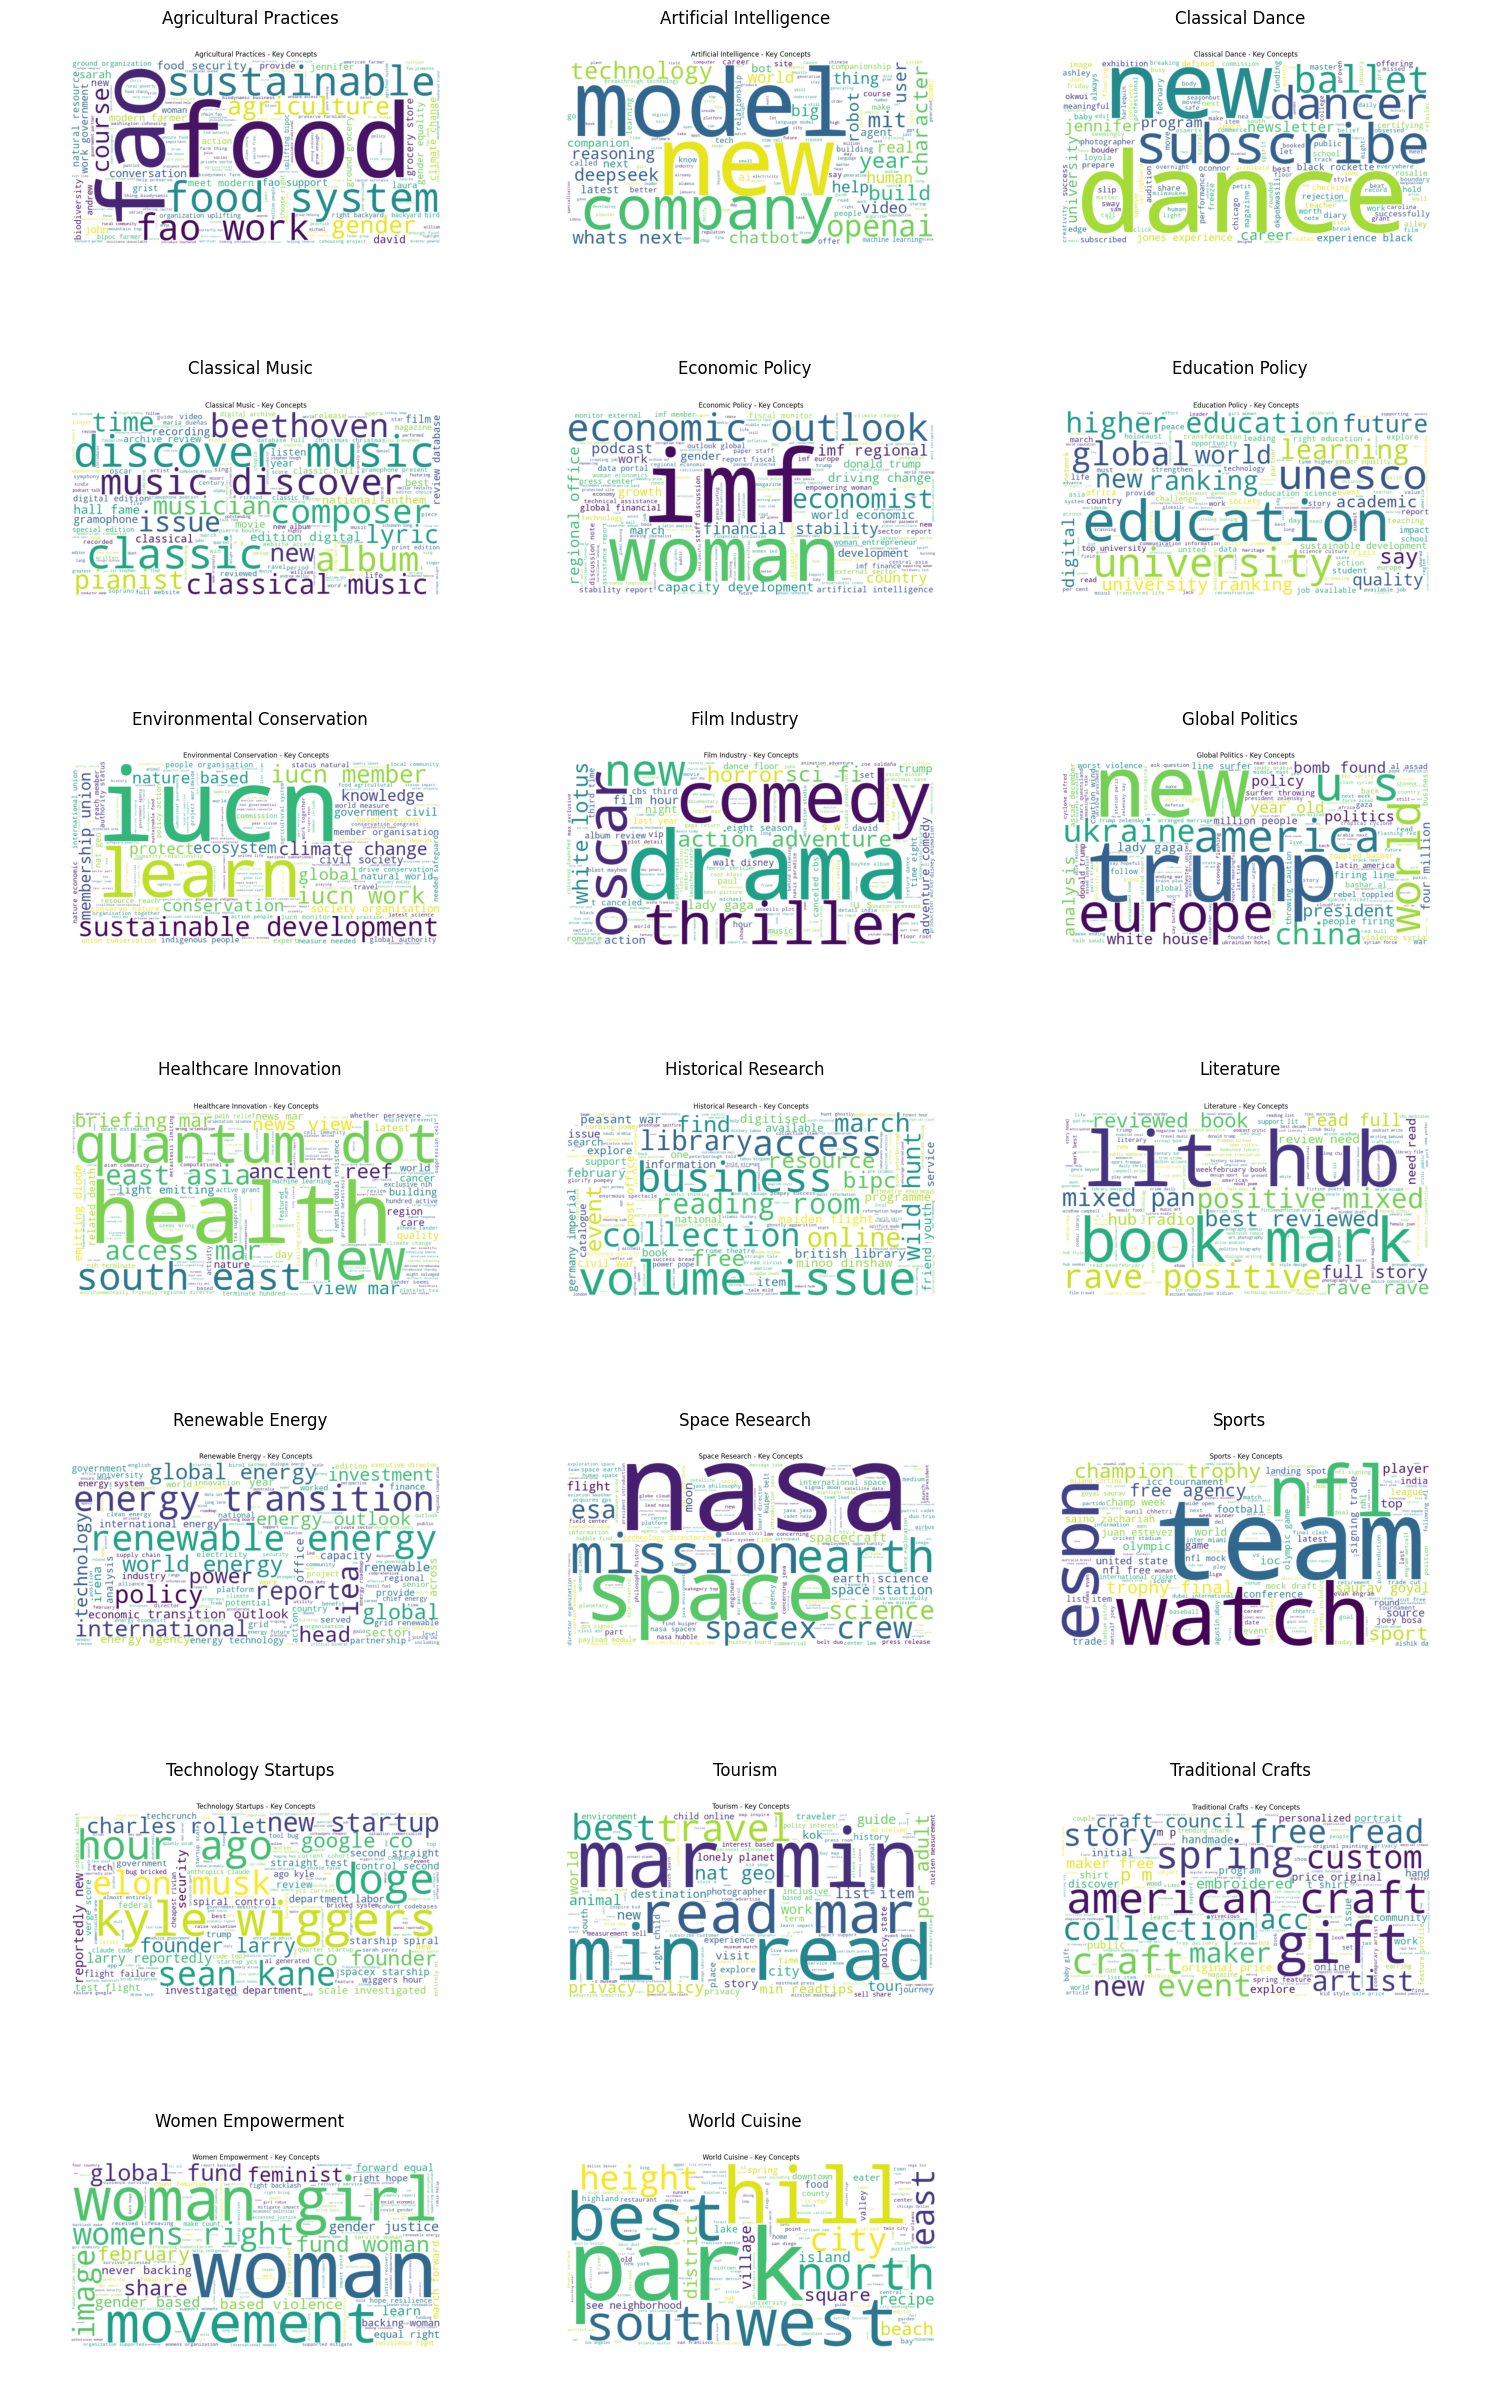

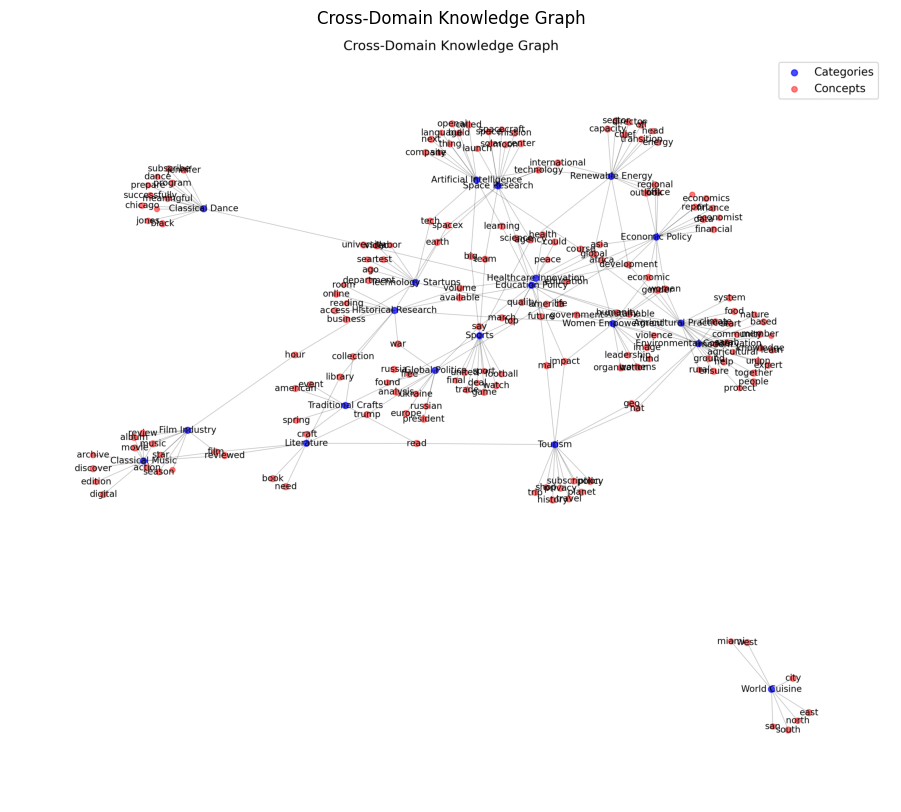

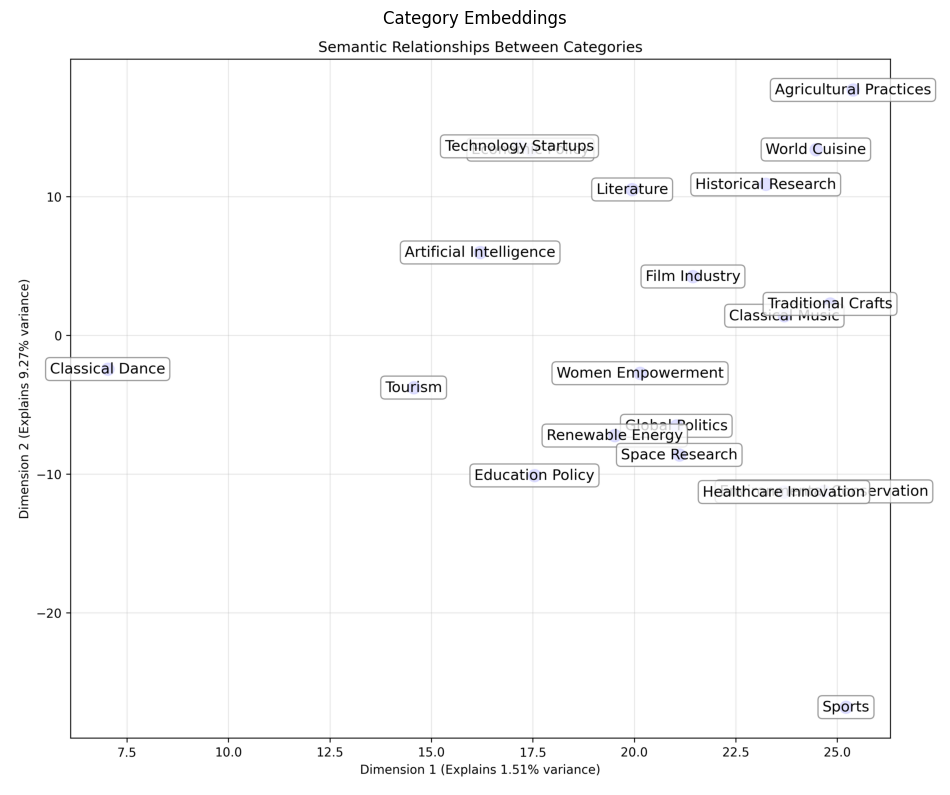

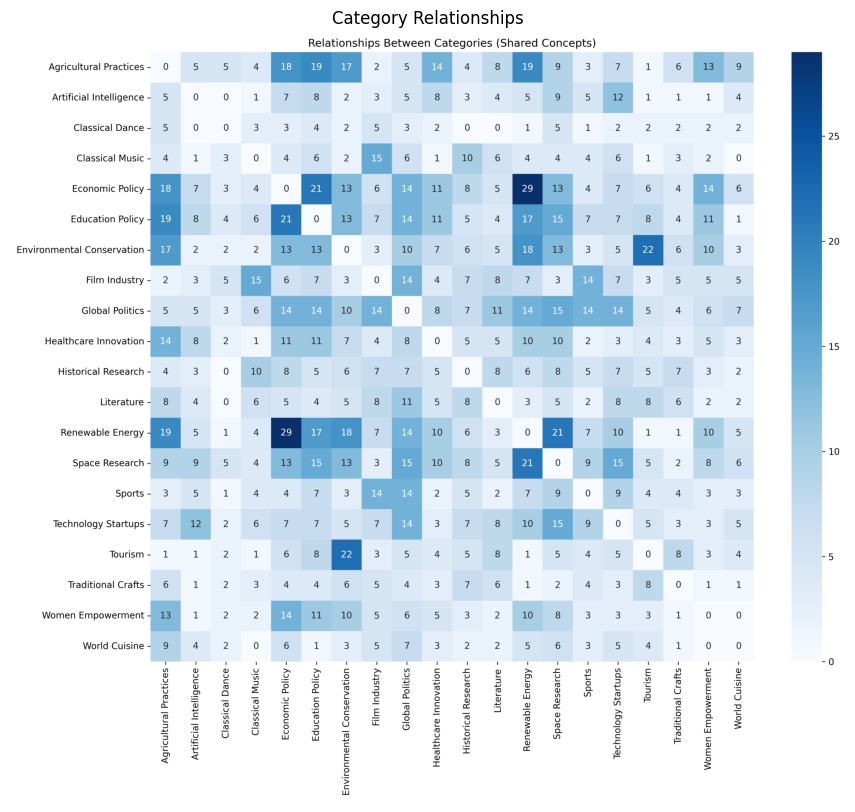

# Cross-Domain Knowledge Analysis Report

## Summary

- **Total Categories Analyzed:** 20
- **Total Concepts Extracted:** 500
- **Knowledge Graph Size:** 200 nodes, 243 connections

## Categories Analyzed

- Agricultural Practices
- Artificial Intelligence
- Classical Dance
- Classical Music
- Economic Policy
- Education Policy
- Environmental Conservation
- Film Industry
- Global Politics
- Healthcare Innovation
- Historical Research
- Literature
- Renewable Energy
- Space Research
- Sports
- Technology Startups
- Tourism
- Traditional Crafts
- Women Empowerment
- World Cuisine

## Category Analysis

### Agricultural Practices

#### Key Concepts

- food *(score: 0.4577)*
- farm *(score: 0.2218)*
- farmer *(score: 0.2195)*
- rural *(score: 0.1718)*
- agriculture *(score: 0.1702)*
- community *(score: 0.1255)*
- agricultural *(score: 0.1238)*
- gender *(score: 0.1213)*
- system *(score: 0.1191)*
- start *(score: 0.1095)*

#### Cross-Domain Connections

- **Artificial Intelligence**: help (8)
- **Classical Music**: start (4)
- **Economic Policy**: gender (32), climate (17), government (11), woman (5), agriculture (4)
- **Education Policy**: sustainable (15), gender (7), ensure (5), system (4), climate (4)
- **Environmental Conservation**: sustainable (39), government (21), climate (21), help (12), food (8)
- **Film Industry**: gender (6)
- **Global Politics**: government (14), climate (7), sustainable (6)
- **Healthcare Innovation**: help (7), climate (6), gender (5), woman (4), modern (4)
- **Historical Research**: start (5), help (5)
- **Literature**: food (7), government (4), help (4), modern (3), climate (3)
- **Renewable Energy**: sustainable (25), climate (25), government (11), system (10), ensure (10)
- **Space Research**: system (18), climate (15), ground (10), help (10), ensure (4)
- **Technology Startups**: government (42), sarah (14), help (6), system (4), ground (3)
- **Traditional Crafts**: community (5), sustainable (4), garden (4)
- **Women Empowerment**: gender (25), sustainable (7), ground (6), ensure (6), woman (6)
- **World Cuisine**: food (19), garden (3)

### Artificial Intelligence

#### Key Concepts

- model *(score: 0.3306)*
- openai *(score: 0.2301)*
- company *(score: 0.1780)*
- character *(score: 0.1757)*
- technology *(score: 0.1689)*
- whats *(score: 0.1639)*
- robot *(score: 0.1437)*
- companion *(score: 0.1416)*
- bot *(score: 0.1416)*
- next *(score: 0.1376)*

#### Cross-Domain Connections

- **Agricultural Practices**: course (23), build (10), thing (9), learning (5)
- **Economic Policy**: technology (12), site (8), learning (7), course (4), big (3)
- **Education Policy**: learning (27), language (6), build (6), technology (5)
- **Environmental Conservation**: relationship (8)
- **Film Industry**: big (22), thing (8), next (3)
- **Global Politics**: next (10), company (8), technology (6), tech (6)
- **Healthcare Innovation**: called (8), learning (7), machine (7), language (5), model (3)
- **Historical Research**: company (3)
- **Literature**: technology (6)
- **Renewable Energy**: technology (31), next (9), company (4)
- **Space Research**: technology (48), next (18), whats (9), learning (6), called (5)
- **Sports**: big (21), next (6)
- **Technology Startups**: tech (35), openai (19), big (11), company (7), next (7)
- **World Cuisine**: next (3), tech (3)

### Classical Dance

#### Key Concepts

- dance *(score: 0.6684)*
- dancer *(score: 0.2513)*
- jennifer *(score: 0.2010)*
- jones *(score: 0.1381)*
- subscribe *(score: 0.1329)*
- successfully *(score: 0.1114)*
- diary *(score: 0.1114)*
- rejection *(score: 0.1114)*
- audition *(score: 0.1114)*
- defined *(score: 0.1114)*

#### Cross-Domain Connections

- **Agricultural Practices**: jennifer (10), ashley (5), university (4), jones (3), program (3)
- **Classical Music**: jones (5), university (4), subscribe (3)
- **Economic Policy**: program (8), edge (3), university (3)
- **Education Policy**: university (30), subscribe (3), teacher (3)
- **Environmental Conservation**: subscribe (3), photographer (3)
- **Film Industry**: dance (12), black (12), jennifer (8), chicago (7), jones (6)
- **Global Politics**: subscribe (8), meaningful (7), black (5)
- **Healthcare Innovation**: rejection (5), defined (4)
- **Renewable Energy**: university (20)
- **Space Research**: successfully (15), program (12), prepare (9), university (9), black (3)
- **Sports**: prepare (4)
- **Technology Startups**: program (8), subscribe (4)
- **Tourism**: subscribe (4), photographer (3)
- **Traditional Crafts**: baby (10), meaningful (3)
- **Women Empowerment**: meaningful (5), program (4)
- **World Cuisine**: university (12), chicago (7)

### Classical Music

#### Key Concepts

- music *(score: 0.5766)*
- classic *(score: 0.3915)*
- album *(score: 0.2529)*
- recording *(score: 0.2127)*
- composer *(score: 0.2030)*
- discover *(score: 0.1893)*
- anthem *(score: 0.1257)*
- edition *(score: 0.1228)*
- fame *(score: 0.1160)*
- hall *(score: 0.1047)*

#### Cross-Domain Connections

- **Agricultural Practices**: archive (5), discover (4), reviewed (4)
- **Artificial Intelligence**: digital (4)
- **Economic Policy**: digital (14), review (9), discover (3), listen (3)
- **Education Policy**: digital (12), discover (5)
- **Film Industry**: film (50), review (38), music (27), album (21), movie (15)
- **Global Politics**: film (7), music (6), album (6), fame (6), review (4)
- **Healthcare Innovation**: digital (4)
- **Historical Research**: review (5), film (5), edition (4), archive (4), digital (4)
- **Literature**: reviewed (18), film (11), music (8)
- **Renewable Energy**: edition (8), review (4)
- **Space Research**: digital (7), complete (5), discover (3), database (3)
- **Sports**: complete (3), player (3)
- **Technology Startups**: review (9), digital (9), archive (4), listen (3)
- **Traditional Crafts**: discover (9), digital (6)

### Economic Policy

#### Key Concepts

- financial *(score: 0.2605)*
- economic *(score: 0.2273)*
- woman *(score: 0.2224)*
- outlook *(score: 0.2223)*
- note *(score: 0.1736)*
- stability *(score: 0.1681)*
- report *(score: 0.1648)*
- office *(score: 0.1516)*
- regional *(score: 0.1483)*
- development *(score: 0.1411)*

#### Cross-Domain Connections

- **Agricultural Practices**: gender (31), development (15), data (11), economic (7), country (7)
- **Artificial Intelligence**: data (5)
- **Education Policy**: development (17), africa (10), data (8), gender (7), report (5)
- **Environmental Conservation**: development (28), economic (8), finance (5), gender (5), economics (4)
- **Film Industry**: america (10), financial (6), gender (6), report (5), office (4)
- **Global Politics**: america (21), africa (12), asia (7), economic (3), office (3)
- **Healthcare Innovation**: asia (12), regional (11), development (5), gender (5), data (5)
- **Historical Research**: office (7), america (4)
- **Renewable Energy**: outlook (44), development (28), regional (27), office (24), report (20)
- **Space Research**: development (20), data (20), america (14), asia (6), africa (6)
- **Sports**: report (4)
- **Technology Startups**: data (14), report (5), housing (3)
- **Women Empowerment**: gender (25), economic (13), woman (6), report (6), development (6)
- **World Cuisine**: financial (3)

### Education Policy

#### Key Concepts

- education *(score: 0.7791)*
- university *(score: 0.2828)*
- ranking *(score: 0.2571)*
- higher *(score: 0.1307)*
- learning *(score: 0.1137)*
- global *(score: 0.1015)*
- development *(score: 0.0716)*
- quality *(score: 0.0708)*
- job *(score: 0.0665)*
- peace *(score: 0.0558)*

#### Cross-Domain Connections

- **Agricultural Practices**: sustainable (30), development (15), global (12), future (12), quality (11)
- **Artificial Intelligence**: learning (12), future (4), top (4), say (3)
- **Classical Dance**: university (3)
- **Classical Music**: life (5), university (4), global (3), humanity (3)
- **Economic Policy**: development (44), global (32), africa (18), future (11), job (9)
- **Environmental Conservation**: sustainable (39), development (28), global (22), humanity (16), science (14)
- **Film Industry**: life (10), say (8), global (6), future (5), peace (4)
- **Global Politics**: africa (12), future (10), global (9), science (7), life (6)
- **Healthcare Innovation**: science (17), life (12), future (9), quality (8), learning (7)
- **Historical Research**: available (10), impact (3)
- **Literature**: science (8), life (7)
- **Renewable Energy**: global (65), development (28), sustainable (25), university (20), africa (18)
- **Space Research**: science (75), development (20), future (14), global (13), top (12)
- **Sports**: top (18), ranking (6), available (6), say (3)
- **Technology Startups**: top (17), science (15), global (6), life (4), available (4)
- **Tourism**: impact (7)
- **Traditional Crafts**: life (7), sustainable (4), impact (3)
- **Women Empowerment**: impact (20), global (15), sustainable (7), development (6), peace (6)
- **World Cuisine**: university (12)

### Environmental Conservation

#### Key Concepts

- conservation *(score: 0.3551)*
- nature *(score: 0.3366)*
- ecosystem *(score: 0.2305)*
- organisation *(score: 0.2066)*
- union *(score: 0.1890)*
- member *(score: 0.1718)*
- sustainable *(score: 0.1640)*
- development *(score: 0.1386)*
- humanity *(score: 0.1384)*
- learn *(score: 0.1374)*

#### Cross-Domain Connections

- **Agricultural Practices**: sustainable (30), climate (22), development (15), people (14), government (9)
- **Artificial Intelligence**: people (6)
- **Classical Music**: organisation (3), humanity (3)
- **Economic Policy**: development (44), climate (17), government (11), based (7), union (6)
- **Education Policy**: development (17), sustainable (15), knowledge (4), climate (4), together (3)
- **Film Industry**: union (8), people (5)
- **Global Politics**: people (19), government (14), climate (7), conservation (6), sustainable (6)
- **Healthcare Innovation**: nature (13), based (13), climate (6), development (5), people (5)
- **Historical Research**: people (10)
- **Literature**: member (7), people (5), government (4), climate (3)
- **Renewable Energy**: development (28), sustainable (25), climate (25), member (12), government (11)
- **Space Research**: development (20), climate (15), together (7), sustainable (4), people (4)
- **Technology Startups**: government (42), people (7), based (4), protect (3)
- **Tourism**: nat (10), geo (10), learn (3), based (3), protect (3)
- **Traditional Crafts**: learn (6), people (5), sustainable (4), membership (4), together (3)
- **Women Empowerment**: based (10), learn (9), sustainable (7), development (6)
- **World Cuisine**: union (6), expert (4), together (3)

### Film Industry

#### Key Concepts

- drama *(score: 0.3068)*
- comedy *(score: 0.2518)*
- oscar *(score: 0.2316)*
- horror *(score: 0.2106)*
- thriller *(score: 0.2066)*
- adventure *(score: 0.1590)*
- film *(score: 0.1588)*
- action *(score: 0.1246)*
- hollywood *(score: 0.1239)*
- win *(score: 0.1206)*

#### Cross-Domain Connections

- **Agricultural Practices**: action (5)
- **Classical Music**: music (78), album (21), film (10), review (9), oscar (5)
- **Economic Policy**: review (9)
- **Education Policy**: action (6)
- **Environmental Conservation**: action (17)
- **Global Politics**: gaga (10), lady (10), film (7), win (7), music (6)
- **Healthcare Innovation**: season (8), exclusive (7), action (4)
- **Historical Research**: film (5), hour (5), review (5)
- **Literature**: film (11), music (8)
- **Renewable Energy**: action (16), review (4)
- **Space Research**: action (3)
- **Sports**: season (5), star (4), exclusive (3)
- **Technology Startups**: action (9), review (9)
- **Traditional Crafts**: studio (3)
- **Women Empowerment**: action (10)
- **World Cuisine**: hollywood (7), star (3)

### Global Politics

#### Key Concepts

- trump *(score: 0.3813)*
- bbc *(score: 0.2481)*
- president *(score: 0.1810)*
- europe *(score: 0.1350)*
- found *(score: 0.1222)*
- america *(score: 0.1204)*
- china *(score: 0.1182)*
- gaza *(score: 0.1159)*
- ukraine *(score: 0.1080)*
- russian *(score: 0.1001)*

#### Cross-Domain Connections

- **Agricultural Practices**: found (3), say (3)
- **Artificial Intelligence**: say (3)
- **Economic Policy**: europe (25), america (18), trump (10), found (4), ukraine (4)
- **Education Policy**: europe (7), say (7), america (5), gaza (3)
- **Environmental Conservation**: analysis (8), war (4), red (4)
- **Film Industry**: trump (16), war (14), america (10), president (9), say (8)
- **Healthcare Innovation**: analysis (12), trump (5), europe (3), gaza (3)
- **Historical Research**: war (27), america (4)
- **Literature**: trump (12), war (7), ukraine (5), russia (4), gaza (3)
- **Renewable Energy**: analysis (11), wind (10), ukraine (8), america (7), europe (6)
- **Space Research**: america (14), president (12), europe (10), russia (6), china (5)
- **Sports**: league (7), canada (6), president (4), found (3), say (3)
- **Technology Startups**: trump (21), russian (11), war (4), russia (4), analysis (3)
- **Traditional Crafts**: found (4)
- **Women Empowerment**: president (6)
- **World Cuisine**: red (3)

### Healthcare Innovation

#### Key Concepts

- mar *(score: 0.2992)*
- health *(score: 0.2798)*
- cell *(score: 0.1889)*
- quantum *(score: 0.1690)*
- dot *(score: 0.1491)*
- disease *(score: 0.1315)*
- briefing *(score: 0.1166)*
- pain *(score: 0.1094)*
- reef *(score: 0.1094)*
- science *(score: 0.1091)*

#### Cross-Domain Connections

- **Agricultural Practices**: could (21), health (6), ancient (5), disease (3), science (3)
- **Artificial Intelligence**: could (8)
- **Economic Policy**: asia (25), health (7), could (7)
- **Education Policy**: science (13), asia (5), health (3)
- **Environmental Conservation**: science (14), mar (8)
- **Film Industry**: mar (9)
- **Global Politics**: could (22), health (8), science (7), asia (7)
- **Historical Research**: volume (32), ancient (5)
- **Literature**: science (8)
- **Renewable Energy**: related (6), asia (6), science (4), enhancing (3)
- **Space Research**: science (75), health (6), scientific (6), asia (6), scientist (4)
- **Sports**: could (11)
- **Technology Startups**: could (19), science (15), health (11)
- **Tourism**: mar (32)
- **Women Empowerment**: health (3)
- **World Cuisine**: coral (3)

### Historical Research

#### Key Concepts

- volume *(score: 0.4258)*
- library *(score: 0.2086)*
- war *(score: 0.2005)*
- business *(score: 0.1938)*
- collection *(score: 0.1652)*
- reading *(score: 0.1526)*
- march *(score: 0.1207)*
- pope *(score: 0.1198)*
- imperial *(score: 0.1198)*
- room *(score: 0.1190)*

#### Cross-Domain Connections

- **Agricultural Practices**: access (18), business (5)
- **Artificial Intelligence**: wild (3), online (3)
- **Classical Music**: access (7), march (5), library (3), british (3), london (3)
- **Economic Policy**: march (24), access (14), business (9), reading (6), online (6)
- **Education Policy**: available (10), march (9), access (6)
- **Environmental Conservation**: war (4), business (4), access (4), room (3), online (3)
- **Film Industry**: business (16), war (14), collection (5), british (3)
- **Global Politics**: war (25), business (15), pope (6), earth (4), access (3)
- **Healthcare Innovation**: volume (9), access (4), available (4)
- **Literature**: march (16), war (7), reading (7), library (6), room (3)
- **Renewable Energy**: access (12), march (4), british (4), london (4)
- **Space Research**: earth (66), march (25), business (8), library (3), access (3)
- **Sports**: march (7), available (6), room (3)
- **Technology Startups**: business (11), access (11), online (10), war (4), march (4)
- **Tourism**: room (3), online (3)
- **Traditional Crafts**: collection (8), online (7)
- **Women Empowerment**: march (15)
- **World Cuisine**: bread (5), london (3)

### Literature

#### Key Concepts

- lit *(score: 0.4119)*
- hub *(score: 0.3423)*
- book *(score: 0.2837)*
- literary *(score: 0.1961)*
- pan *(score: 0.1961)*
- positive *(score: 0.1947)*
- fiction *(score: 0.1416)*
- criticism *(score: 0.1373)*
- reviewed *(score: 0.1350)*
- read *(score: 0.1186)*

#### Cross-Domain Connections

- **Agricultural Practices**: reviewed (4), mark (4), need (3)
- **Artificial Intelligence**: book (3), read (3), need (3)
- **Classical Music**: reviewed (10), film (10), library (3)
- **Economic Policy**: trump (10), read (6), bookstore (6), book (5), need (5)
- **Education Policy**: read (4), need (4)
- **Environmental Conservation**: book (3)
- **Film Industry**: film (50), trump (16), need (5), book (4), novel (3)
- **Global Politics**: trump (72), read (8), film (7), book (4), daily (3)
- **Healthcare Innovation**: read (5), trump (5), novel (3), need (3)
- **Historical Research**: library (18), read (6), film (5)
- **Renewable Energy**: need (3)
- **Space Research**: hub (4), library (3)
- **Sports**: need (3)
- **Technology Startups**: trump (21), need (6), read (4), fiction (3), rss (3)
- **Tourism**: read (34), book (3)
- **Traditional Crafts**: craft (76), read (18), hub (4)
- **World Cuisine**: need (4), pan (3)

### Renewable Energy

#### Key Concepts

- energy *(score: 0.6917)*
- renewable *(score: 0.2462)*
- transition *(score: 0.2292)*
- outlook *(score: 0.2224)*
- iea *(score: 0.2224)*
- global *(score: 0.1115)*
- grid *(score: 0.1083)*
- chief *(score: 0.0849)*
- technology *(score: 0.0796)*
- international *(score: 0.0772)*

#### Cross-Domain Connections

- **Agricultural Practices**: development (15), sector (15), global (12), director (6), energy (5)
- **Artificial Intelligence**: technology (11), off (3)
- **Classical Music**: global (3), director (3)
- **Economic Policy**: development (44), regional (41), office (38), outlook (34), global (32)
- **Education Policy**: global (33), development (17), international (11), technology (5), cooperation (5)
- **Environmental Conservation**: development (28), global (22), international (12), transition (4), agency (4)
- **Film Industry**: director (17), off (17), global (6), head (6), office (4)
- **Global Politics**: global (9), off (7), technology (6), head (4), energy (3)
- **Healthcare Innovation**: regional (11), director (6), development (5), global (4), chief (4)
- **Historical Research**: office (7), international (6)
- **Literature**: technology (6), international (4)
- **Space Research**: technology (48), international (40), agency (20), development (20), global (13)
- **Sports**: agency (20), international (18), off (4)
- **Technology Startups**: chief (18), agency (7), off (7), energy (6), global (6)
- **Traditional Crafts**: off (30)
- **Women Empowerment**: global (15), international (7), energy (6), renewable (6), transition (6)
- **World Cuisine**: off (9), director (4)

### Space Research

#### Key Concepts

- nasa *(score: 0.7361)*
- space *(score: 0.3027)*
- earth *(score: 0.1940)*
- science *(score: 0.1347)*
- mission *(score: 0.1210)*
- launch *(score: 0.1120)*
- crew *(score: 0.1093)*
- moon *(score: 0.1001)*
- technology *(score: 0.0972)*
- exploration *(score: 0.0967)*

#### Cross-Domain Connections

- **Agricultural Practices**: international (4), science (3), launch (3)
- **Artificial Intelligence**: technology (11)
- **Economic Policy**: international (16), center (15), technology (12), mission (7), team (3)
- **Education Policy**: science (13), international (11), technology (5), agency (4)
- **Environmental Conservation**: science (14), international (12), space (6), mission (4), agency (4)
- **Film Industry**: team (5), crew (4)
- **Global Politics**: moon (9), science (7), spacex (7), technology (6), station (6)
- **Healthcare Innovation**: science (17), center (9), moon (4), international (3)
- **Historical Research**: earth (9), international (6), team (4)
- **Literature**: science (8), technology (6), international (4)
- **Renewable Energy**: international (45), technology (31), agency (22), solar (14), science (4)
- **Sports**: agency (20), team (19), international (18), center (4)
- **Technology Startups**: spacex (27), science (15), moon (11), spacecraft (10), space (8)
- **Tourism**: mission (3)
- **Women Empowerment**: mission (8), international (7), team (5)
- **World Cuisine**: center (11), mission (5), station (4)

### Sports

#### Key Concepts

- final *(score: 0.2557)*
- olympic *(score: 0.2499)*
- champion *(score: 0.2108)*
- trophy *(score: 0.2078)*
- team *(score: 0.1803)*
- india *(score: 0.1764)*
- trade *(score: 0.1620)*
- watch *(score: 0.1532)*
- football *(score: 0.1517)*
- signing *(score: 0.1417)*

#### Cross-Domain Connections

- **Agricultural Practices**: free (16), top (10), united (3)
- **Artificial Intelligence**: big (8), top (4), watch (3)
- **Classical Music**: final (4), player (3)
- **Economic Policy**: watch (8), team (3), big (3)
- **Education Policy**: top (14), united (9), agency (4)
- **Environmental Conservation**: united (5), agency (4), watch (3)
- **Film Industry**: big (22), watch (10), spot (8), champion (6), game (6)
- **Global Politics**: united (12), football (10), trade (9), watch (8), sport (8)
- **Healthcare Innovation**: free (5)
- **Historical Research**: free (9), team (4)
- **Literature**: draft (6)
- **Renewable Energy**: agency (22), trade (8), team (4), united (3)
- **Space Research**: team (23), agency (20), top (12), free (4), big (4)
- **Technology Startups**: watch (22), top (17), game (16), big (11), agency (7)
- **Tourism**: watch (3)
- **Traditional Crafts**: free (27)
- **Women Empowerment**: team (5)

### Technology Startups

#### Key Concepts

- startup *(score: 0.3274)*
- kyle *(score: 0.2790)*
- reportedly *(score: 0.2273)*
- doge *(score: 0.2133)*
- google *(score: 0.1804)*
- ago *(score: 0.1568)*
- founder *(score: 0.1460)*
- sean *(score: 0.1455)*
- kane *(score: 0.1455)*
- hour *(score: 0.1454)*

#### Cross-Domain Connections

- **Agricultural Practices**: government (9), charles (3)
- **Artificial Intelligence**: video (7), tech (7), user (4)
- **Classical Music**: video (5), hour (3)
- **Economic Policy**: government (11), labor (4), department (3), tech (3)
- **Education Policy**: department (3)
- **Environmental Conservation**: government (21)
- **Film Industry**: video (19), ago (16), sean (11), labor (7), charles (5)
- **Global Politics**: government (14), video (12), ago (8), starship (8), test (8)
- **Historical Research**: hour (5)
- **Literature**: musk (4), government (4), elon (3)
- **Renewable Energy**: government (11), department (8), video (4)
- **Space Research**: spacex (27), video (11), department (10), test (8), tech (3)
- **Sports**: kyle (6)
- **World Cuisine**: video (3), tech (3)

### Tourism

#### Key Concepts

- min *(score: 0.7190)*
- mar *(score: 0.3670)*
- read *(score: 0.2455)*
- nat *(score: 0.1672)*
- geo *(score: 0.1672)*
- adult *(score: 0.1509)*
- travel *(score: 0.1285)*
- per *(score: 0.1191)*
- privacy *(score: 0.0935)*
- visit *(score: 0.0834)*

#### Cross-Domain Connections

- **Agricultural Practices**: policy (11)
- **Artificial Intelligence**: read (3)
- **Classical Music**: subscription (4)
- **Economic Policy**: policy (12), history (10), read (6), impact (6), planet (3)
- **Education Policy**: impact (11), per (7), planet (6), read (4), adult (3)
- **Environmental Conservation**: policy (22), planet (15), impact (12), history (12), nat (10)
- **Film Industry**: history (12), trip (10), mar (9)
- **Global Politics**: policy (14), read (8), impact (6), travel (5), history (4)
- **Healthcare Innovation**: mar (48), read (5), privacy (3)
- **Historical Research**: history (12), read (6), impact (3)
- **Literature**: read (28), history (15), travel (6), tour (4), privacy (3)
- **Renewable Energy**: policy (20)
- **Space Research**: history (18), policy (12), planet (9), travel (7)
- **Sports**: policy (4), privacy (3), tour (3)
- **Technology Startups**: policy (9), read (4), travel (4), privacy (4), subscription (3)
- **Traditional Crafts**: read (18), history (10), privacy (5), shop (4), travel (3)
- **Women Empowerment**: impact (20), history (5)
- **World Cuisine**: shop (5), travel (3)

### Traditional Crafts

#### Key Concepts

- craft *(score: 0.5352)*
- gift *(score: 0.4709)*
- spring *(score: 0.3029)*
- maker *(score: 0.2294)*
- artist *(score: 0.1476)*
- acc *(score: 0.1429)*
- custom *(score: 0.1366)*
- american *(score: 0.1364)*
- free *(score: 0.1140)*
- exhibition *(score: 0.0986)*

#### Cross-Domain Connections

- **Agricultural Practices**: free (16), american (10), event (4)
- **Artificial Intelligence**: read (3)
- **Classical Music**: american (5)
- **Economic Policy**: spring (6), read (6), american (3), price (3)
- **Education Policy**: read (4)
- **Environmental Conservation**: event (3)
- **Film Industry**: original (7), collection (5), free (4), american (3)
- **Global Politics**: read (8), free (5), american (3)
- **Healthcare Innovation**: american (5), free (5), read (5)
- **Historical Research**: collection (17), free (9), read (6), american (5), spring (3)
- **Literature**: read (28), craft (13), american (7)
- **Space Research**: free (4), material (3)
- **Sports**: free (25), event (4), acc (3)
- **Technology Startups**: event (7), price (4), read (4)
- **Tourism**: read (34), event (3)
- **World Cuisine**: spring (8)

### Women Empowerment

#### Key Concepts

- woman *(score: 0.4296)*
- womens *(score: 0.3587)*
- justice *(score: 0.2158)*
- movement *(score: 0.1925)*
- gender *(score: 0.1879)*
- girl *(score: 0.1746)*
- leadership *(score: 0.1685)*
- violence *(score: 0.1586)*
- organization *(score: 0.1541)*
- humanitarian *(score: 0.1515)*

#### Cross-Domain Connections

- **Agricultural Practices**: gender (31), global (12), economic (7), organization (4), equal (4)
- **Artificial Intelligence**: image (3)
- **Classical Music**: march (5), global (3)
- **Economic Policy**: economic (75), gender (32), global (32), march (24), womens (18)
- **Education Policy**: global (33), impact (11), march (9), gender (7), womens (4)
- **Environmental Conservation**: global (22), impact (12), economic (8), gender (5), justice (4)
- **Film Industry**: image (8), gender (6), global (6), womens (3)
- **Global Politics**: violence (10), global (9), impact (6), hope (5), economic (3)
- **Healthcare Innovation**: gender (5), woman (4), supported (4), global (4)
- **Historical Research**: march (21), impact (3)
- **Literature**: march (16), violence (4)
- **Renewable Energy**: global (65), economic (12), leadership (4), march (4)
- **Space Research**: march (25), organization (17), image (14), global (13), fund (4)
- **Sports**: march (7), movement (6)
- **Technology Startups**: global (6), fund (4), march (4)
- **Tourism**: impact (7)
- **Traditional Crafts**: impact (3)

### World Cuisine

#### Key Concepts

- park *(score: 0.5014)*
- hill *(score: 0.3381)*
- west *(score: 0.2070)*
- height *(score: 0.2049)*
- recipe *(score: 0.1932)*
- district *(score: 0.1796)*
- square *(score: 0.1756)*
- beach *(score: 0.1645)*
- village *(score: 0.1522)*
- south *(score: 0.1407)*

#### Cross-Domain Connections

- **Agricultural Practices**: west (8), city (7), district (3), north (3), san (3)
- **Artificial Intelligence**: city (4), west (3)
- **Economic Policy**: city (9), east (8), south (5), downtown (4), island (3)
- **Film Industry**: west (4), east (4), island (3)
- **Global Politics**: south (10), east (8), north (6), beach (4), miami (4)
- **Healthcare Innovation**: south (12), east (12)
- **Renewable Energy**: south (6), san (3), island (3)
- **Space Research**: south (6), north (6), east (6)
- **Sports**: miami (8), west (5), dallas (4)
- **Technology Startups**: san (6), city (3), valley (3)
- **Tourism**: city (4), south (3)

## Similar Categories

### Agricultural Practices is most similar to:

- World Cuisine *(similarity: 0.3198)*
- Traditional Crafts *(similarity: 0.3080)*
- Women Empowerment *(similarity: 0.2937)*

### Artificial Intelligence is most similar to:

- Technology Startups *(similarity: 0.3609)*
- Space Research *(similarity: 0.2478)*
- Renewable Energy *(similarity: 0.2373)*

### Classical Dance is most similar to:

- Women Empowerment *(similarity: 0.5268)*
- Traditional Crafts *(similarity: 0.4493)*
- Classical Music *(similarity: 0.4064)*

### Classical Music is most similar to:

- Classical Dance *(similarity: 0.4064)*
- Traditional Crafts *(similarity: 0.3279)*
- Tourism *(similarity: 0.3215)*

### Economic Policy is most similar to:

- Women Empowerment *(similarity: 0.3618)*
- Agricultural Practices *(similarity: 0.2820)*
- World Cuisine *(similarity: 0.2405)*

### Education Policy is most similar to:

- Classical Dance *(similarity: 0.3236)*
- Women Empowerment *(similarity: 0.3006)*
- Healthcare Innovation *(similarity: 0.2642)*

### Environmental Conservation is most similar to:

- Tourism *(similarity: 0.7056)*
- Women Empowerment *(similarity: 0.4040)*
- Traditional Crafts *(similarity: 0.3600)*

### Film Industry is most similar to:

- Traditional Crafts *(similarity: 0.2723)*
- Classical Dance *(similarity: 0.2463)*
- Classical Music *(similarity: 0.2306)*

### Global Politics is most similar to:

- Literature *(similarity: 0.2652)*
- Sports *(similarity: 0.2516)*
- Classical Dance *(similarity: 0.2458)*

### Healthcare Innovation is most similar to:

- Environmental Conservation *(similarity: 0.2812)*
- Women Empowerment *(similarity: 0.2748)*
- Education Policy *(similarity: 0.2642)*

### Historical Research is most similar to:

- Traditional Crafts *(similarity: 0.3191)*
- Classical Music *(similarity: 0.3033)*
- Tourism *(similarity: 0.2947)*

### Literature is most similar to:

- Classical Dance *(similarity: 0.3568)*
- Tourism *(similarity: 0.3349)*
- World Cuisine *(similarity: 0.3237)*

### Renewable Energy is most similar to:

- Women Empowerment *(similarity: 0.2808)*
- Sports *(similarity: 0.2655)*
- Artificial Intelligence *(similarity: 0.2373)*

### Space Research is most similar to:

- Environmental Conservation *(similarity: 0.3346)*
- Historical Research *(similarity: 0.2656)*
- Tourism *(similarity: 0.2495)*

### Sports is most similar to:

- Environmental Conservation *(similarity: 0.3328)*
- Tourism *(similarity: 0.3098)*
- Classical Dance *(similarity: 0.2838)*

### Technology Startups is most similar to:

- Artificial Intelligence *(similarity: 0.3609)*
- World Cuisine *(similarity: 0.2771)*
- Classical Music *(similarity: 0.2296)*

### Tourism is most similar to:

- Environmental Conservation *(similarity: 0.7056)*
- World Cuisine *(similarity: 0.4479)*
- Traditional Crafts *(similarity: 0.3640)*

### Traditional Crafts is most similar to:

- Classical Dance *(similarity: 0.4493)*
- Tourism *(similarity: 0.3640)*
- Environmental Conservation *(similarity: 0.3600)*

### Women Empowerment is most similar to:

- Classical Dance *(similarity: 0.5268)*
- Environmental Conservation *(similarity: 0.4040)*
- Economic Policy *(similarity: 0.3618)*

### World Cuisine is most similar to:

- Tourism *(similarity: 0.4479)*
- Environmental Conservation *(similarity: 0.3494)*
- Literature *(similarity: 0.3237)*



In [10]:
# Example usage
if __name__ == "__main__":
    # Create loader with path to analysis folder
    loader = VisualizationLoader("Task1_b/CrossDomainAnalysis")
    
    # Display all available files
    loader.list_all_files()
    
    # Display wordclouds
    loader.display_wordclouds()
    
    # Display knowledge graph
    loader.display_knowledge_graph()
    
    # Display category embeddings
    loader.display_category_embeddings()
    
    # Display category relationships
    loader.display_category_relationships()
    
    # Display report
    loader.display_report()

## Use case